# Проект. Определение региона для добычи нефти

## Описание проекта

Добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину. Имеются пробы нефти в трех регионах, в каждом из которых 10000 месторождений. Пробы представляют собой измерения качества нефти и объема ее запасов. Необходимо построить модель машинного обученя, которая поможет определить регион, где добыча принесет наибольшую прибыль. 

**Условия задачи**:
* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона проводится исследование 500 точек.
* Бюджет на разработку месторождений — 10 млрд рублей, стоимость бурения одной скважины — 50 млн рублей.
* Один баррель сырья приносит 4500 рублей прибыли.
* Не рассматривать регионы, в которых риск убытков выше 2.5%. Из оставшихся выбирается регион с наибольшей средней прибылью.

## Цели проекта

* Подготовить данные
* Построить модель и оценить объем запасов нефти в каждом регионе
* Проанализировать возможную прибыль и риски техникой Bootstrap
* Предложить регион для разработки месторождений и обосновать выбор

------

## 1. Загрузка и подготовка данных

Импортируем необходимые модули и библиотеки.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt 

Прочитаем данные о регионах и сохраним их в переменных `reg_1`, `reg_2` и `reg_3`.

In [2]:
reg_1 = pd.read_csv('/datasets/geo_data_0.csv')
reg_2 = pd.read_csv('/datasets/geo_data_1.csv')
reg_3 = pd.read_csv('/datasets/geo_data_2.csv')

Посмотрим на данные, выведем первые 5 строк, иноформацию о данных, таблицу с статистическими характеристиками, проверим наличие дубликатов и уникальность идентификаторов месторождений. Автоматизируем эту операцию для показа информации сразу трех регионов.

In [3]:
names = [reg_1, reg_2, reg_3]
number = 0
for i in names:
    number += 1
    print('РЕГИОН ',number, '\n', i.head(), '\n')
    print(i.info())
    print(i.describe())
    print('Уникальность идентификаторов месторождений: ', i['id'].nunique())
    print('Наличие дубликатов: ', i.duplicated().sum(), '\n\n')

РЕГИОН  1 
       id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%       

Датасеты имеют по 5 столбцов и 10000 строк. Имеется столбец идентификатор месторождения, три столбца признака:  *'f0, f1, f2'* и целевой признак *'product'*, который показывает объем запасов месторождения в тысячах баррелей. Целевой признак - количественный, поэтому в данном проекте будет решаться задача регрессии. Пропусков в данных нет, признаки - численные. Полных дубликатов строк в данных нет. Небольшое количество идентификаторов месторождений повторяется. Посмотрим на строки с повторяющимися идентификаторами.

In [4]:
for i in names:    
    print(i[i['id'].duplicated(keep=False)].sort_values(by='id'),'\n')

          id        f0        f1         f2     product
66136  74z30  1.084962 -0.312358   6.990771  127.643327
64022  74z30  0.741456  0.459229   5.153109  140.771492
51970  A5aEY -0.180335  0.935548  -2.094773   33.020205
3389   A5aEY -0.039949  0.156872   0.209861   89.249364
69163  AGS9W -0.933795  0.116194  -3.655896   19.230453
42529  AGS9W  1.454747 -0.479651   0.683380  126.370504
931    HZww2  0.755284  0.368511   1.863211   30.681774
7530   HZww2  1.061194 -0.373969  10.430210  158.828695
63593  QcMuo  0.635635 -0.473422   0.862670   64.578675
1949   QcMuo  0.506563 -0.323775  -2.215583   75.496502
75715  Tdehs  0.112079  0.430296   3.218993   60.964018
21426  Tdehs  0.829407  0.298807  -0.049563   96.035308
92341  TtcGQ  0.110711  1.022689   0.911381  101.318008
60140  TtcGQ  0.569276 -0.104876   6.440215   85.350186
89582  bsk9y  0.398908 -0.400253  10.122376  163.433078
97785  bsk9y  0.378429  0.005837   0.160827  160.637302
41724  bxg6G -0.823752  0.546319   3.630479   93

Проанализировав данную информацию, можно предположить, что дубликаты идентификаторов месторождений возникли по причине обновления информации о них, либо это просто ошибки в данных. В любом случае, этих дубликатов не так много и разные численные признаки дубликатов месторождений соответствуют разным показателям объемов запасов, поэтому решено оставить эти строки. Данные готовы к обучению моделей.

------

## 2. Обучение и проверка модели

По условию задачи будем использовать модель линейной регрессии.

In [5]:
result = [] # создаем пустой список для сохранения результата
number = 0 

# Для автоматизации операций создаем цикл
for i in names:
    # сохраним признаки и целевой признак в переменных
    target = i['product']
    features = i.drop(['product', 'id'], axis=1)
    
    # разделим выборки на тренировочную и валидационную в соотношении 75:25
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)
    
    # построим модель линейной регрессии и получим предсказания
    model = LinearRegression()
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    
    # сохраним предсказания и правильные ответы в перменную result
    result.append(predicted_valid)
    result.append(target_valid)
    
    # выведем на экран номер региона, средний запас сырья, метрики R2, MAE и RMSE
    mse = mean_squared_error(target_valid, predicted_valid)
    number += 1
    print('РЕГИОН ', number)
    print('Средний запас сырья: {:.2f}'.format(predicted_valid.mean()))
    print("R2 = {:.2f}".format(r2_score(target_valid, predicted_valid)))
    print('MAE = {:.2f}'.format(mean_absolute_error(target_valid, predicted_valid)))
    print('RMSE = {:.2f}'.format(mse**0.5), '\n')

РЕГИОН  1
Средний запас сырья: 92.59
R2 = 0.28
MAE = 30.92
RMSE = 37.58 

РЕГИОН  2
Средний запас сырья: 68.73
R2 = 1.00
MAE = 0.72
RMSE = 0.89 

РЕГИОН  3
Средний запас сырья: 94.97
R2 = 0.21
MAE = 32.79
RMSE = 40.03 



* Результаты предсказаний и метрики получились интересные. Результаты предсказаний моделей в первом и третьем регионах получились похожими (метрика RMSE около 40). Во втором регионе модель линейная регрессия работает "идеально" (R2 = 1, RMSE = 0.89), но средний запас сырья заметно меньше, чем в остальных регионах.

Сохраним результаты предсказаний и правильные ответы моделей в виде таблицы, для этого преобразуем `result` в датафрейм и проименуем названия столбцов.

In [6]:
result = pd.DataFrame(data=result).T

In [7]:
result.columns=['pred_reg_1', 'target_reg_1', 'pred_reg_2', 'target_reg_2', 'pred_reg_3', 'target_reg_3']

Посмотрим, что получилось.

In [8]:
result

,pred_reg_1,target_reg_1,pred_reg_2,target_reg_2,pred_reg_3,target_reg_3
0,95.894952,10.038645,82.663314,80.859783,93.599633,61.212375
1,77.572583,114.551489,54.431786,53.906522,75.105159,41.850118
2,77.892640,132.603635,29.748760,30.132364,90.066809,57.776581
3,90.175134,169.072125,53.552133,53.906522,105.162375,100.053761
4,70.510088,122.325180,1.243856,0.000000,115.303310,109.897122
...,...,...,...,...,...,...
24995,103.037104,170.116726,136.869211,137.945408,78.765887,28.492402
24996,85.403255,93.632175,110.693465,110.992147,95.603394,21.431303
24997,61.509833,127.352259,137.879341,137.945408,99.407281,125.487229
24998,118.180397,99.782700,83.761966,84.038886,77.779912,99.422903


Для того, чтобы "понять", почему получились такие предсказания моделей, посмотрим на распределение целевых признаков у регионов. Построим гистограммы.

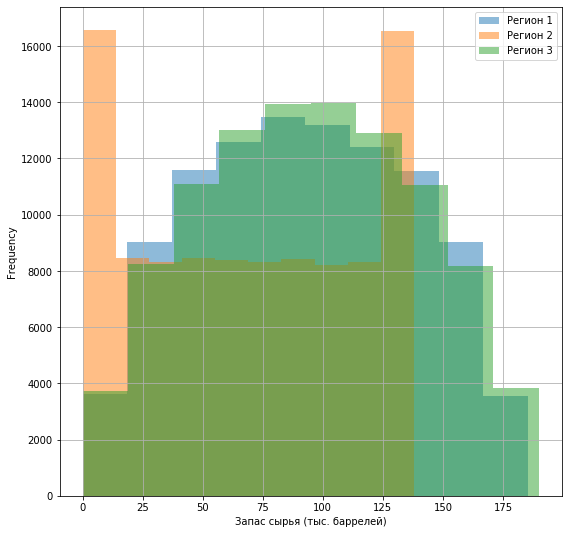

In [9]:
count = 0
for i in names:
    count +=1
    i['product'].plot(kind='hist', alpha=0.5, label='Регион '+str(count), grid=True, figsize=(9,9))
    plt.legend()
plt.xlabel('Запас сырья (тыс. баррелей)');

* Из гистограмм видно, что распределение значений в 1 и 3 регионах напоминает нормальное. Во втором регионе распределение значений довольно странное, как бы искусственное. Имеется два строгих максимума по краям графика, а между ними значения распределены равномерно. 

Отобразим графически взаимовлияние значений столбцов таблицы `reg_2`.

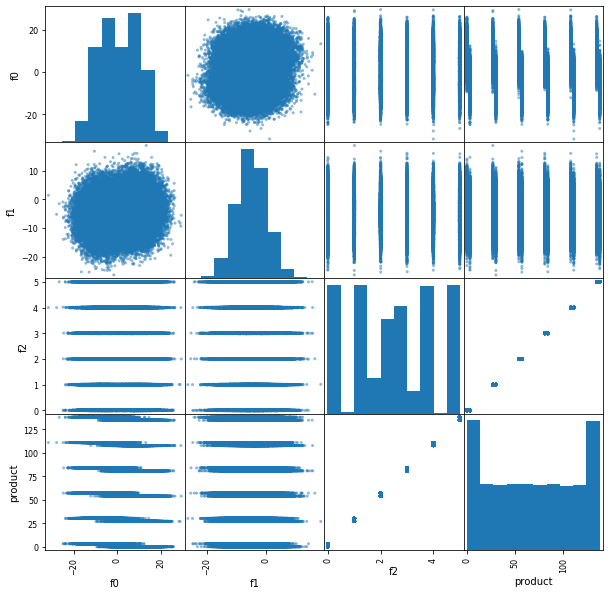

In [10]:
pd.plotting.scatter_matrix(reg_2, figsize=(10, 10));

* Судя по графикам влияния признаков на целевой признак, наблюдается четкая линейная зависимость целевого признака от признаков, именно поэтому линейная регрессия в данном случае работает так хорошо. Скорее всего эти данные имеют искусственное происхождение и недостоверны, либо часть данных была утеряна.

------

## 3. Подготовка к расчёту прибыли

Сохраним в переменных ключевые значения для расчета прибыли

In [11]:
points = 500             # число точек
budget = 10000000000     # бюджет на разработку месторождений (в рублях)
cost = 50000000          # стоимость бурения одной скважины (в рублях)
barrel = 4500            # прибыль с одного барреля сырья (в рублях)

Посчитаем минимальный средний объём сырья в месторождениях региона, достаточный для его разработки.

In [12]:
min_volume = budget / barrel

Выведем результат на экран.

In [13]:
print('{:.0f} барреля'.format(min_volume))

2222222 барреля


* Для того, чтобы разработка новых месторождений в регионе окупалась, запасы нефти в нем должны быть не меньше 2,22 млн баррелей. Это будет являться условием при проверке регионов на риск убытков.

Напишем функцию для расчёта прибыли по набору отобранных месторождений и предсказаний модели.

In [14]:
def revenue(probabilities, count): # на вход функция получает предсказания и количество пробуренных скважин
    # сортируем значения по убыванию, чтобы взять для подсчета прибыли месторождения с максимальными запасами сырья
    probs_sorted = probabilities.sort_values(ascending=False)
    # выбираем месторождения исходя из нужного количества
    selected = probs_sorted[:count]
    return barrel * selected.sum() # возвращаем прибыль

Все готово для расчета прибыли.

------

## 4. Расчёт прибыли и рисков 

Посчитаем прибыль для каждого региона, применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

In [15]:
state = np.random.RandomState(12345) # обеспечим "случайность" гиперпараметру random_state при создании выборок

In [16]:
for n in range(1, 4, 1): # создаем цикл от 1 до 3
    # сохраняем нужные значения столбцов таблицы result в переменные
    target = result['target_reg_' + str(n)] * 1000 # умножаем на 1000, так как значения в таблице в тыс. баррелей
    probabilities = result['pred_reg_' + str(n)] * 1000
    
    # сюда будут записываться результаты расчета прибыли предсказанных и реальных значений
    values_probs = []
    values_target = []
    
    # создаем новый цикл для Bootstrap
    for i in range(1000):
        # извлекаем из выборки probabilities 500 случайных значений
        probs_subsample = probabilities.sample(n=points, replace=True, random_state=state)
        
        # выбираем из выборки target значения по индексам выбранных 500 случайных значений
        target_subsample = target[probs_subsample.index]
        
        # считаем прибыль по предсказаниям и соответствующим им реальным значениям
        # при бюджете 10 млрд рублей можно пробурить 200 скважин
        res_probs = revenue(probs_subsample, int(budget / cost))
        res_target = revenue(target_subsample, int(budget / cost))
        
        # записываем полученную прибыль в переменные values_probs и values_target
        values_probs.append(res_probs)
        values_target.append(res_target)
    
    # создаем из списков values_probs и values_target объекты Series
    values_probs = pd.Series(values_probs)
    values_target = pd.Series(values_target)
    
    # находим нижнюю и верхнюю границы 95%-го доверительного интервала
    lower = values_probs.quantile(0.025)
    upper = values_probs.quantile(0.975)
    
    # считаем средние значения прибыли предсказаний и реальных значений
    mean_probs = values_probs.mean()
    mean_target = values_target.mean()
    
    # выводим на экран номер региона, среднюю прибыль предсказаний и реальных значений, доверительный интервал,
    # для оценки риска убытков выведем на экран минимальный объем сырья и объем сырья, соответствующий нижней границе
    # доверительного интервала - 2.5%
    print('Регион', n)
    print('Средняя прибыль реальных значений: {:.0f} рублей'.format(mean_target))
    print('Средняя прибыль предсказаний: {:.0f} рублей'.format(mean_probs))
    print('95%-й доверительный интервал: {:.0f} - {:.0f} рублей'.format(lower, upper))
    print('Требуемый минимальный средний объём сырья: {:.0f} баррелей'.format(min_volume))
    print('Средний объем сырья месторождения, соответствующий нижнему\nзначению доверительного интервала прибыли (2.5 %): {:.0f} баррелей\n'
          .format(lower / barrel))

Регион 1
Средняя прибыль реальных значений: 123577156593 рублей
Средняя прибыль предсказаний: 103580260542 рублей
95%-й доверительный интервал: 101401373360 - 105988772714 рублей
Требуемый минимальный средний объём сырья: 2222222 баррелей
Средний объем сырья месторождения, соответствующий нижнему
значению доверительного интервала (2.5 %): 22533639 баррелей

Регион 2
Средняя прибыль реальных значений: 104625220366 рублей
Средняя прибыль предсказаний: 104591672842 рублей
95%-й доверительный интервал: 100760478225 - 108616321298 рублей
Требуемый минимальный средний объём сырья: 2222222 баррелей
Средний объем сырья месторождения, соответствующий нижнему
значению доверительного интервала (2.5 %): 22391217 баррелей

Регион 3
Средняя прибыль реальных значений: 126265892146 рублей
Средняя прибыль предсказаний: 102717422041 рублей
95%-й доверительный интервал: 100911157075 - 104522088825 рублей
Требуемый минимальный средний объём сырья: 2222222 баррелей
Средний объем сырья месторождения, соотве

------

## Выводы

Для удобного сравнения полученных результатов сведем их в таблицу.

Характеристика / Регион | Регион 1 | Регион 2 | Регион 3 |
:--- | :---: | :---: | :---: |
 | | | |
Средний запас сырья в месторождении (тыс. баррелей) | 92.59 | 68.73 | 94.97 |
Метрика RMSE | 37.58 | 0.89 | 40.03 |
 | | | |
Средняя прибыль реальных значений (млрд руб)| 123.6 | 104.6 | 126.3 |
Средняя прибыль предсказаний (млрд руб)| 103.6 | 104.6 | 102.7 |
95%-й доверительный интервал (млрд руб)| 101.4 - 106.0 | 100.8 - 108.6 | 100.9 - 104.5 |
 | | | |
Минимальный средний объём сырья (млн баррелей) | | 2.22 | |
Средний объем сырья месторождения, соответствующий нижнему
значению доверительного интервала прибыли 2.5 % (млн баррелей) | 22.5 | 22.4 | 22.4 |


* Целью проекта является выбор самого выгодного региона для разработки новых месторождений нефти. Прежде чем сравнивать полученные результаты, исключаем из выбора "Регион 2", по причинам, описанным выше, хотя и средняя прибыль у него получилась самая большая. Из оставшихся регионов, для разработки выбираем "Регион 1", так как средняя прибыль у него выше и  95% квантиль доверительного интервала больше, чем у "Региона 2". Также результаты предсказаний у модели первого региона получились немного точнее, судя по метрике RMSE.
* Насчет риска убытков. В сегменте "Хватит ли запасов сырья для получения прибыли?" риски убытков отсутствуют, так как средний объем сырья месторождения, соответствующий нижнему значению доверительного интервала прибыли 2.5 % превышает минимальный средний объем сырья больше, чем в 10 раз.
* Также следует добавить, что прибыль от разработки месторождений возможно будет еще больше, чем предсказывает модель, так как средняя прибыль реальных значений, которые соответствуют предсказаниям, получилась на 20 млрд. рублей больше.

------